### Test 4
## Point cloud reconstruction from real photos
In this notebook we shift from synthetic images to real photos for 3d reconstruction. Given a "noisy" photo of an object from any view, we want to remove undesired parts (e.g. the background, other objects, shadows) to obtain a "clean" point cloud. 
We identify two possible pipelines:
1. **Image segmentation** (e.g. the [Watershed algorithm](https://en.wikipedia.org/wiki/Watershed_(image_processing))) to extract the subject: it requires identifying the segmented part of the image to keep according to prior knowledge.

2. Background removal with Deep Neural Networks ([U^2-Net, Qin et al. 2022](https://arxiv.org/pdf/2005.09007.pdf)): we use a neural backbone meant for **Salient Object Detection**, that is the identification of the most contextually relevant objects of the image. Without any kind of supervision, it allows us to achieve the same result for background removal.

Subsequently, we choose to use Multi-view Point-E based on [stochastic conditioning](/halixness/point-e/tree/main/sc_point_e), as it is more computationally efficient while yielding more object-consistent results. We compare the generated point-cloud with the one obtained with single-view conditioning, in which some object parts are occluded.


In [1]:
from PIL import Image
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from rembg import remove

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Image loading and background removal with UNet**

*[RemBG](https://github.com/danielgatis/rembg)* is a high level framework based on the ONNX framework (for optimized execution), it includes implementations of U^2-Net with pre-trained weights ([paper](https://arxiv.org/pdf/2005.09007.pdf)).

In [3]:
image_size = 256
views = []
files = ["IMG_6328.png", "IMG_6329.png", "IMG_6330.png", "IMG_6331.png"]

for f in files:
    img = Image.open(f)
    img = img.resize((image_size, image_size))
    
    # BG removal with simple ONNX APIs (pre-trained U2Net model)
    img = remove(img)
    views.append(img)

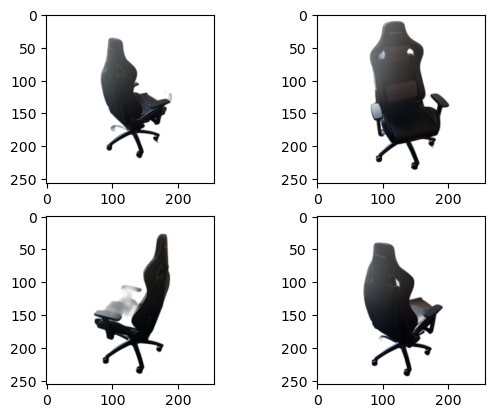

In [4]:
# Plotting the views
num_views = len(files)
cols = 2
rows = (num_views // cols)

f, axarr = plt.subplots(rows, cols)
for i in range(num_views):
    axarr[i // cols, i % cols].imshow(np.asarray(views[i]))

### Multi-view, stochastic conditioning, Point-E

In [5]:
PILtoTensor = transforms.ToTensor()

In [6]:
# Stochastic conditioning branch
from sc_point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from sc_point_e.diffusion.sampler import PointCloudSampler
from sc_point_e.models.download import load_checkpoint
from sc_point_e.models.configs import MODEL_CONFIGS, model_from_config
from sc_point_e.util.plotting import plot_point_cloud

In [7]:
base_name = 'base300M' # base40M, use base300M or base1B for better results

# Instantiate Point-E 300M with pre-trained weights
print('creating base model...')
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [8]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096-1024], # points in cloud and missing ones for upsampling
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

**Feeding a single view**

In [9]:
# Sample a point cloud iteratively (default: 1024 denoising steps from config)
samples = None
# the second frame is chosen for single-view conditioning
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[views[1]]))):
    samples = x

0it [00:00, ?it/s]

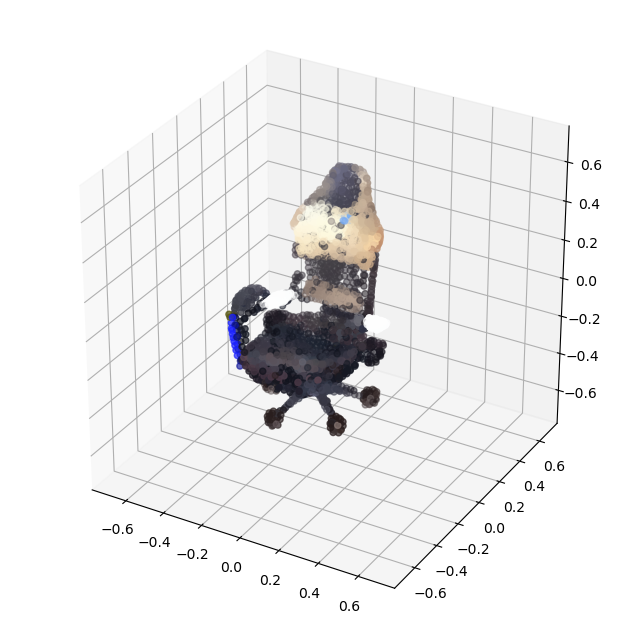

In [10]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

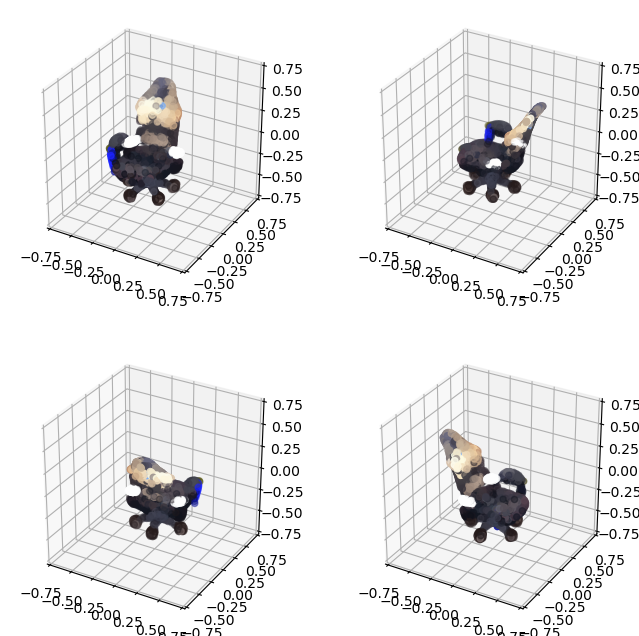

In [11]:
fig = plot_point_cloud(pc, grid_size=2, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

**Feeding multiple views**

In [ ]:
# Sample a point cloud iteratively (default: 1024 denoising steps from config)
samples = None
# All the loaded views are used
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=views))):
    samples = x

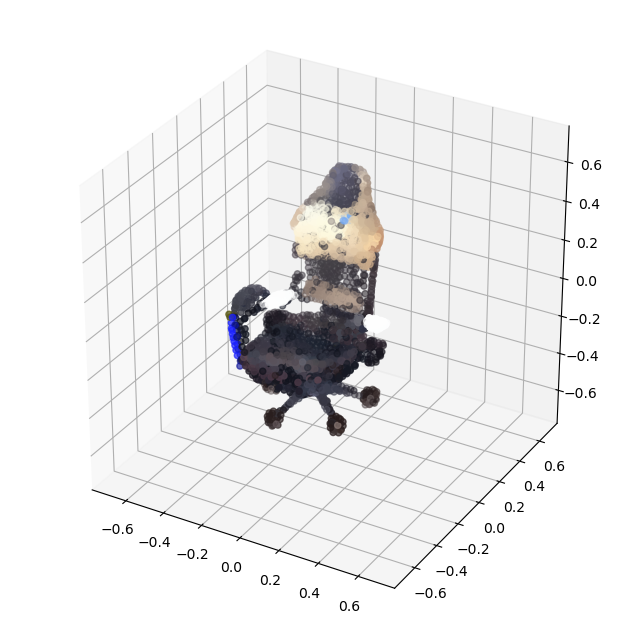

In [12]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

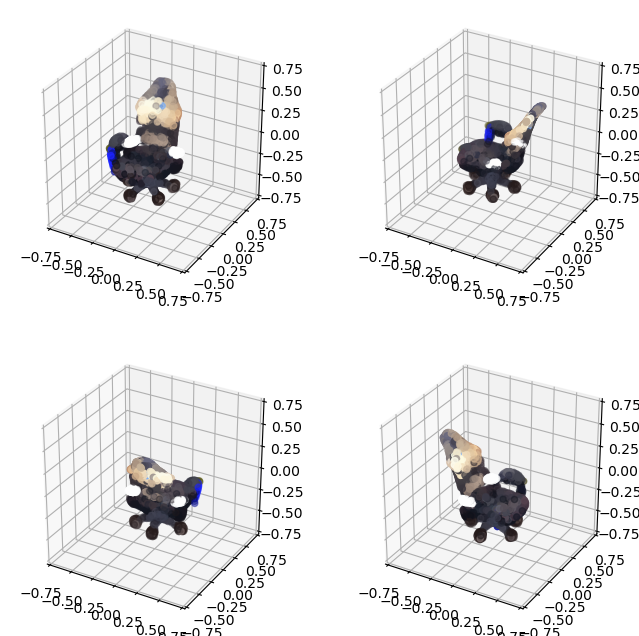

In [13]:
fig = plot_point_cloud(pc, grid_size=2, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))